In [1]:
# run this ONCE to install FlowCal
#!pip install FlowCal

#imports
import os
import FlowCal    
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from scipy import linalg
import statistics


In [2]:
#list to hhold individual dataframe for all cel lines (excl. controls)
cell_line_dataframes = []
# directory containing fcs files
filesdir = './data/Single cell proteomics/'
# all directories containing cell line data
cell_line_directories = os.listdir(filesdir)

# list to hold all filenames
list_of_files = []

# control file regex regexes
ctrl_regex = re.compile('_a313_HCC70_(\S+)_0_egf_singlets_egf.fcs.fcs')

# regex that includes timestamp
#cellname_regex = re.compile('_[b-z]\d+_(\S+)_[A-B]_\d+_')

# regex that handles full samples also
# original regex was _[b-z]\d+_(\S+)_[A-B]_, but missed the following cell lines
# BT483
# HCC70 1 and 2
# MCF12A
# mdakb2
# MDAMB157
# MDAMB231

# aregex for cell line samples with cell line capture group
cellname_regex = re.compile('_[a-z]\d+_(\S+)_[A-B]_')

FileNotFoundError: [Errno 2] No such file or directory: './data/Single cell proteomics/'

In [4]:
# Run this once to organise cell line samples
# dictionary of conrols to normalize cell line sample data
cell_lines_ctrls = {} 

# iterate through the folders which contain the fcs file
for directory in cell_line_directories:
    # fetch all samples from the current directory
    cell_line_samples = os.listdir(filesdir + directory) # all cell line files in sub folders
    
    # OR: first we have to find the control
    # OR: this might be either HCC70 or MDAMB453, let's pick HCC70
    # OR: second, actually, HCC70 samples enter each folder in different way
    # OR: we can normalize data either on samples like _a313_HCC70_..., or _c122_ZR7530_A_0_HCC70_...
    # OR: we will focus on _a313_HCC70_... because they seem to be done from the same bacth, accoring to paper's Methods
    
    # dictionary allows us to find the control file for each cell line more easily 
    # control files can be found by using the .get function w/ dictionaries
    # e.g. cell_line_ctrls.get('BT474')
    
    
    # loop through each sample (file in cell line folder)
    for sample in cell_line_samples:
        # search for any file that is a control file
        srch = ctrl_regex.search(sample)
        
        # check if the sample is a control
        if srch:
            # this line is only excecuted when there is a match for a control file
            cell_lines_ctrls[srch.group(1)] = sample
    

NameError: name 'cell_line_directories' is not defined

In [3]:
# repeat the same iteration as above, but search for non control cell line samples


# iterate through the folders which contain the fcs file
for directory in cell_line_directories:
    cell_line_samples = os.listdir(filesdir + directory) # all cell line files in sub folders
    
    # using the control dictionary allows us to find the control file for each cell line more easily 
    # control files can be found by using the .get function w/ dictionaries
    # e.g. cell_line_ctrls.get('BT474')
    
    # loop through each sample (file in cell line folder)
    for sample in cell_line_samples:
        # search for sample that is not a control sample
        srch_ctrl = cellname_regex.search(sample)
        
        # if sample is a regular sample (not a control)
        if srch_ctrl:
            # print('Normalizing ' + sample + ' on ' + cell_lines_ctrls[srch_ctrl.group(1)]) # this is just a check that we are normalizing on proper values
            
            # generate fcs data
            fcs_data_from_file = FlowCal.io.FCSData(filesdir + directory + '/' + sample)
            # create dataframe from fcs
            dataframe_from_fcs = pd.DataFrame(fcs_data_from_file, columns=fcs_data_from_file.channels).mean(axis=0)
            
            # find the control for the associated cell line
            # e.g. if file is _d110_BT474_A_13_iPI3K_singlets_iPI3K.fcs.fcs
            # then the control will be _a313_HCC70_BT474_0_egf_singlets_egf.fcs.fcs
            ctrl_fcs = FlowCal.io.FCSData(filesdir + directory + '/' + cell_lines_ctrls[srch_ctrl.group(1)])
            ctrl_df = pd.DataFrame(ctrl_fcs, columns=ctrl_fcs.channels).mean(axis=0)
            
            # noramlize the datat and append data frame for one sample to array of all samples
            cell_line_dataframes.append(dataframe_from_fcs/ctrl_df) 
            # add sample to list of files (to be used for naming columns)
            list_of_files.append(sample)
            
    


NameError: name 'cell_line_directories' is not defined

In [3]:
# create a new dataframe from array of individual dataframes, use .T (transpose)
# transpose is used to allow the channels to be rows and cell line samples to be columns
# this dataframe contains the average value across each channel for every sample
all_samples_df = pd.DataFrame(cell_line_dataframes).T

# set the column names to be the name of the file for reference
all_samples_df.columns = list_of_files
display(all_samples_df)


""


In [4]:
# the above iterations are taxing on computer resources, so I have written the df to a csv
# i can read in the csv rather than run the above iterations repeatedly

# write all_samples_df to csv (save processing time)
# all_samples_df.to_csv('all_samples_df.csv')

# read inthe csv file for use
all_samples_df = pd.read_csv('all_samples_df.csv', index_col=0)
list_of_files = all_samples_df.columns

In [5]:
# Here, e replace the channels/isotopes with the repective targets. A copy of the original df is taken and modified to exclude
# channels that do not have an associated target
copy = all_samples_df.copy(deep=True)

## read in excel file to fetch targets and associated channels
antibodies = pd.read_excel('./cytof_antibodies.xlsx',index_col=0)

# the dictionary used to map the isotope value to the target value
cell_to_target = {}

# loop through each isotope. fetche the isotope names from the first column of the excel
for iso_name in antibodies.index:
    # generate list of channels appending 'Di'
    antibodies.loc[iso_name,'channel'] = iso_name + 'Di'

#loop through all rows in the table (so all channels, incl time, event_length etc)
for iso_name in all_samples_df.index.values:
    # if the row is one of the non isotope rows, skip
    if iso_name in ['Time', 'Event_length','Center','Offset', 'Width', 'Residual', 'FileNum', 'beadDist']:
        continue
    # if the isotope does not have an equivalent target in the antibodies excel sheet, drop it from the table    
    elif iso_name not in antibodies.channel.values:
        copy.drop(index=iso_name, axis=0, inplace=True)
    else: 
        # otherwise update the dictionary with the isotope and its corresponding target 
        # iso_name[0:len(iso_name) - 2] -> this searches for channel names without 'Di' 
        # in the samples df and replaces it with the target
        cell_to_target[iso_name] = antibodies.loc[iso_name[0:len(iso_name) - 2]].Target

# used the modified/copied df to define full_sample_df_with_targets
full_sample_df_with_targets = copy.rename(index = cell_to_target)

In [6]:
# I would use only antibody information, so SVM will not use unnecessary data
AB_use = list(set(antibodies['Target']).intersection(set(full_sample_df_with_targets.index)))
full_sample_df_with_targets = full_sample_df_with_targets.loc[AB_use].copy()
full_sample_df_with_targets

,_e146_UACC3199_A_0_iPI3K_singlets_iPI3K.fcs.fcs,_e147_UACC3199_A_0_imTOR_singlets_imTOR.fcs.fcs,_e148_UACC3199_A_0_iEGFR_singlets_iEGFR.fcs.fcs,_e149_UACC3199_A_0_iPKC_singlets_iPKC.fcs.fcs,_e150_UACC3199_A_0_iMEK_singlets_iMEK.fcs.fcs,_e151_UACC3199_A_0_HCC70_singlets_HCC70.fcs.fcs,_e152_UACC3199_A_15_HCC70_singlets_HCC70.fcs.fcs,_e153_UACC3199_A_full_full_singlets_full.fcs.fcs,_e154_UACC3199_A_0_egf_singlets_egf.fcs.fcs,_e155_UACC3199_A_13_iPI3K_singlets_iPI3K.fcs.fcs,...,_d526_CAL851_B_0_iMEK_singlets_iMEK.fcs.fcs,_d527_CAL851_B_9_egf_singlets_egf.fcs.fcs,_d528_CAL851_B_7_egf_singlets_egf.fcs.fcs,_d529_CAL851_B_17_egf_singlets_egf.fcs.fcs,_d530_CAL851_B_30_egf_singlets_egf.fcs.fcs,_d531_CAL851_B_60_egf_singlets_egf.fcs.fcs,_d532_CAL851_B_7_iPKC_singlets_iPKC.fcs.fcs,_d533_CAL851_B_7_iMEK_singlets_iMEK.fcs.fcs,_d534_CAL851_B_17_iPKC_singlets_iPKC.fcs.fcs,_d535_CAL851_B_17_iMEK_singlets_iMEK.fcs.fcs
p-p53,0.133109,0.092692,0.080955,0.119191,0.135556,0.464885,0.522381,0.131990,0.117202,0.126794,...,0.173964,0.252468,0.189007,0.192172,0.222119,0.205789,0.203992,0.256895,0.196038,0.167921
p-SAPK/JNK,1.157506,0.612462,0.564431,1.160626,0.994583,0.864955,0.971503,0.756093,0.807293,1.462828,...,0.634622,1.219623,0.702847,1.097133,1.208187,0.929949,0.878339,0.965004,0.877228,0.887749
p-MAPKAPK-2,1.322942,1.036210,0.958668,1.155347,1.037079,1.214338,1.732139,1.135564,1.214955,1.712471,...,1.527480,3.008939,2.262351,3.272952,3.869120,3.629777,2.160320,2.132288,2.567607,2.316932
p-BTK,0.823074,0.444445,0.433399,0.769085,0.826988,0.824614,0.643137,0.698881,0.633476,0.638323,...,0.633146,0.877176,0.585896,0.645930,0.669697,0.536622,0.643847,0.757637,0.600954,0.608464
cleaved PARP,0.457607,0.261378,0.302989,0.431052,0.441453,0.412534,0.366252,0.242255,0.395887,0.297391,...,0.365364,0.565342,0.332612,0.495244,0.383637,0.322407,0.414475,0.388609,0.374937,0.379760
Cyclin B1,1.397586,0.595730,0.608191,1.271542,1.228842,0.891462,0.756062,1.837485,1.128319,1.239540,...,1.333868,2.340005,1.490450,2.080253,1.844328,1.180023,1.663190,2.249862,1.369471,1.315899
GAPDH,3.818324,2.853503,2.894186,4.912111,6.449775,0.989435,0.796885,4.741372,3.968896,4.571211,...,0.899988,1.358415,0.938019,0.873747,1.119821,0.873228,0.945044,1.154105,1.056707,0.945877
p-S6,1.454962,0.837490,1.778192,1.518428,2.004015,1.544202,4.588704,2.607092,1.763081,2.642221,...,1.812006,3.643668,2.973812,4.444878,7.064676,7.296491,1.576738,1.939327,6.187588,6.602286
p-MEK1/2,1.155223,0.931361,0.911643,1.070581,1.497841,1.109857,0.982209,1.133258,1.074707,1.371965,...,0.761422,1.443276,1.298268,1.048837,0.955202,0.845369,1.117615,1.504638,0.964307,1.582600
p-SRC,0.721329,0.496569,0.431894,0.498034,0.592942,0.778134,0.733615,0.731270,0.678216,0.521145,...,0.383978,0.490626,0.349327,0.452215,0.506625,0.468086,0.397543,0.430068,0.404784,0.465365


In [7]:
# Create a new dataframe that contains only the full samples for all cell lines referenced in cell_line_and_subtype.xlsx
# create a regex to identify full samples form the large table of samples
full_sample_file_regex=re.compile('.*_full_full_.*')
list_of_full_sample_files = list_of_files

# create full list of 'full sample files' (e.g '_e244_UACC3199_B_full_full_singlets_full.fcs.fcs') 
# from complete list of filenames. Use regex to filter full list
list_of_full_sample_files = list(filter(full_sample_file_regex.search, list_of_full_sample_files))

print(len(list_of_full_sample_files))
# list dataframes of all '_full_' dataframes
list_of_full_sample_dfs = []
full_sample_df = pd.DataFrame()
# loop through all columns in the large table to extract the columns of the 
# full sample files

for column in full_sample_df_with_targets:
    if full_sample_df_with_targets[column].name in list_of_full_sample_files:
        list_of_full_sample_dfs.append(full_sample_df_with_targets[column])
full_sample_df = pd.DataFrame(list_of_full_sample_dfs).T

130


In [8]:
# Dear Amy, picking full samples can be done simpler
full_sample_df=full_sample_df_with_targets.filter(regex='_full_full_')
full_sample_df

,_e153_UACC3199_A_full_full_singlets_full.fcs.fcs,_e244_UACC3199_B_full_full_singlets_full.fcs.fcs,_e269_184A1_A_full_full_singlets_full.fcs.fcs,_e360_184A1_B_full_full_singlets_full.fcs.fcs,_b994_HCC1428_A_full_full_singlets_full.fcs.fcs,_c244_AU565_B_full_full_singlets_full.fcs.fcs,_c331_HCC1428_B_full_full_singlets_full.fcs.fcs,_c8_AU565_A_full_full_singlets_full.fcs.fcs,_c736_HCC202_A_full_full_singlets_full.fcs.fcs,_d12_HCC202_B_full_full_singlets_full.fcs.fcs,...,_c508_ZR751_B_full_full_singlets_full.fcs.fcs,_c66_ZR751_A_full_full_singlets_full.fcs.fcs,_b240_UACC893_A_full_full_singlets_full.fcs.fcs,_b418_UACC893_B_full_full_singlets_full.fcs.fcs,_c182_T47D_A_full_full_singlets_full.fcs.fcs,_c624_T47D_B_full_full_singlets_full.fcs.fcs,_b389_ZR75B_B_full_full_singlets_full.fcs.fcs,_b66_ZR75B_A_full_full_singlets_full.fcs.fcs,_d427_CAL851_A_full_full_singlets_full.fcs.fcs,_d518_CAL851_B_full_full_singlets_full.fcs.fcs
p-p53,0.131990,0.120221,0.081407,0.092066,0.681934,7.370715,0.769438,8.560815,0.182257,0.153368,...,0.183899,0.198231,0.220387,0.189839,1.044486,1.366550,0.722316,1.083552,0.155498,0.143369
p-SAPK/JNK,0.756093,0.601207,1.262352,0.797161,1.067416,0.647177,0.902934,0.772304,0.863816,0.760108,...,0.684145,0.985517,0.798026,0.545592,0.983343,0.751683,0.769781,1.102467,0.757544,0.665003
p-MAPKAPK-2,1.135564,1.209894,0.502161,0.665603,1.774594,0.619865,1.655016,0.790473,0.846818,0.730942,...,1.382451,1.459881,1.431541,1.091484,1.209485,1.001043,1.180373,1.476333,2.779158,2.173954
p-BTK,0.698881,0.559051,0.680980,0.600050,1.410787,0.540688,1.517093,0.707124,0.703619,0.749956,...,0.776452,0.970305,0.708173,0.541705,0.946103,0.884789,0.959190,1.213958,0.772385,0.719247
cleaved PARP,0.242255,0.222390,0.418463,0.395555,0.373136,0.219317,0.339741,0.157750,0.493022,0.647915,...,0.136186,0.163593,0.284241,0.355999,0.229868,0.187267,0.220028,0.215100,0.376638,0.414830
Cyclin B1,1.837485,1.172252,2.438772,3.495540,0.934922,0.340430,0.701479,0.408710,0.988524,0.521503,...,1.486630,2.172566,1.326752,0.750864,3.094042,2.705663,1.917818,2.196491,2.772026,1.798709
GAPDH,4.741372,4.754228,0.386869,0.515839,5.483497,1.557605,7.034888,2.251441,0.425689,0.468645,...,1.946789,2.595468,0.689631,0.527411,0.712369,0.692164,2.034913,2.452389,0.916242,0.925716
p-S6,2.607092,3.850464,1.637951,2.597898,4.465406,3.612563,5.680459,3.799611,1.834553,2.663389,...,4.364974,4.406985,5.848515,4.691517,5.092825,6.311919,9.349040,7.714652,4.875464,7.288674
p-MEK1/2,1.133258,0.893081,0.961174,1.205959,1.337688,0.983225,1.211136,1.009945,1.846048,1.619182,...,1.314098,1.428825,0.749994,0.656908,1.076516,1.001486,0.934096,0.925719,1.323671,0.973931
p-SRC,0.731270,0.629521,0.299980,0.404491,1.838001,0.265509,2.160590,0.237776,0.491316,0.587948,...,1.122622,1.604424,0.091107,0.081923,0.562623,0.524960,0.903552,0.855689,0.546498,0.423232


In [9]:
# # import the cell_line and subtype csv file
# # for each cell line, associate the respective column in the datafram with the label of L or B
# # We will use this df as training data


# # copy the full sample to use as training data for SVM
# training_data_samples = full_sample_df.copy(deep=True)

# # rename columns from file names to cell line
# modified_col_names = []
# for col in training_data_samples.columns:
#     col_search = re.search(cellname_regex, col)
#     if col_search:
#         modified_col_names.append(col_search.group(1))
        
# # update df column names, from file name to cell line        
# training_data_samples.columns = modified_col_names

# # Sort the cell lines alphabetically (Upper case take precedence over lower)
# # this training data will be used for both binary and multi dimensional SVM
# training_data_samples = training_data_samples.sort_index(axis=1)

# # since we are focusing on binary classifaction for the moment, use this list to remove any 'Normal Classifications'
# normal_classifications = ['184A1', '184B5', 'HDQP1', 'MCF10A', 'MCF10F', 'MCF12A']

# # For bainary, remove all normal classifications, focusing on Luminal and Basal
# binary_svm_training = training_data_samples.copy(deep=True)

# for column in binary_svm_training:
#     if column not in binary_svm_training.columns:
#         continue
#     if column in normal_classifications:
#         binary_svm_training.drop(column, axis=1, inplace=True)

# # read in the training classifications
# cell_line_and_subtype = pd.read_excel('./cell_line_and_subtype.xlsx',index_col=0) 
# # create labelling array for Luminal and Basal cell line samples only
# # since there is two full samples per cell line, we need two claswifications each

# # filter out any 'Normal' classification
# filtered_classifications = list(filter(lambda type: type != 'Normal', list(cell_line_and_subtype['Type'])))

# #prepare list of binary classifications 
# binary_classification = []

# for classification in filtered_classifications:
#     if classification == 'L':
#         # since there is two samples per cell line, add two classifications to represent each
#         # these can be slit by A and B at a later date if necessary
#         binary_classification = binary_classification + [0, 0]
#     else:
#         binary_classification = binary_classification + [1, 1]

# print(len(binary_classification))

In [10]:
# Begin data prep for Binary and Multi SVM training/classification


# you did termendous job writing the cell above, well done
# let me suggest just an alternative how you can make it simpler next time
cell_line_and_subtype = pd.read_excel('./cell_line_and_subtype.xlsx',index_col=0) 

luminal_cell_names = cell_line_and_subtype.loc[cell_line_and_subtype["Type"]=="L"].index
basal_cell_names = cell_line_and_subtype.loc[cell_line_and_subtype["Type"]=="B"].index
normal_cell_names = cell_line_and_subtype.loc[cell_line_and_subtype["Type"]=="Normal"].index

all_labels = list(cell_line_and_subtype.index)

# in regex "|" means OR, so, we can just make a regex with cell lines names listed using "|"
luminal_samples = full_sample_df.filter(regex='|'.join(luminal_cell_names))
basal_samples = full_sample_df.filter(regex='|'.join(basal_cell_names))
normal_samples = full_sample_df.filter(regex='|'.join(normal_cell_names))

# calculate the centroid of the luminal and centroid samples
luminal_centroid = luminal_samples.mean(axis=1)
basal_centroid = basal_samples.mean(axis=1)
normal_centroid = normal_samples.mean(axis=1)

#binary svm training data
binary_svm_training = pd.concat([luminal_samples,basal_samples],axis=1)
binary_classification = list(np.zeros(len(luminal_samples.columns))) + list(np.ones(len(basal_samples.columns)))


# multi svm training data
multi_svm_training = pd.concat([luminal_samples,basal_samples, normal_samples],axis=1)
multi_classification = list(np.zeros(len(luminal_samples.columns))) + list(np.ones(len(basal_samples.columns))) + list(np.full(len(normal_samples.columns),2))


In [11]:
########## Binary SVM Fit #############


# begin svm training fit
# use linear kernel
# one more important point
# The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. 
# For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane 
# does a better job of getting all the training points classified correctly. 
# Conversely, a very small value of C will cause the optimizer to look for a 
# larger-margin separating hyperplane, even if that hyperplane misclassifies more points.
# We want to have no misclassified cell lines, so I set up high value of C
# if we use default vaule C=1 there will be small amount of misclassified cells
svc = SVC(kernel='linear',C=100)

# to ensure correct dimension matching, the cell lines had to be columns and the sample files as rows
# use display((binary_svm_training.T) to visualise

# the SVC fit resulted in the notebook kernel freezing and was stuck
# Need to figure out if the data is prepared correctly to be used in the training of the SVM
svc.fit(binary_svm_training.T, binary_classification)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

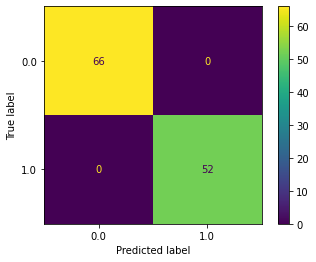

In [12]:
# now let's check how well we have separated
plot_confusion_matrix(svc,binary_svm_training.T,binary_classification)
# with C=100 the consion matrix is diagonal
# if C=1 the amount of misclassified cells with be small but non zero

In [13]:
# now please write down s_vec and norm_vec, and calculate DPD values for all cell lines in full_sample_df
# s_vec, norm_vec for binary SVM
b_coeff_train = - svc.intercept_[0]/linalg.norm(svc.coef_[0])
norm_vec_train = svc.coef_[0]/linalg.norm(svc.coef_[0])
s_vec_train = (basal_centroid - luminal_centroid)/linalg.norm(luminal_centroid - basal_centroid)

angle_train = (np.arccos(np.dot(norm_vec_train,s_vec_train))/np.pi)*180
print(angle_train)

s_vec_norm_vec_df = pd.DataFrame(s_vec_train,index=binary_svm_training.T.columns,columns=['s_vec'])
s_vec_norm_vec_df.insert(0,'norm_vec',norm_vec_train)

s_vec_norm_vec_df.sort_values(by='norm_vec').to_csv('STV_Luminal_Basal.csv')

display(s_vec_norm_vec_df.sort_values(by='norm_vec'))

77.27662608690915


,norm_vec,s_vec
p-STAT5,-0.482688,-0.000243
β-CATENIN,-0.415427,-0.030813
p-S6K,-0.312289,-0.013735
p-BTK,-0.311327,-0.005705
p-SAPK/JNK,-0.166111,-0.008476
p-PDPK1,-0.145912,-0.042122
p-MAP2K3,-0.145370,-0.008294
p-MAPKAPK-2,-0.139947,0.088566
p-MEK1/2,-0.054536,-0.066184
p-GSK3β,-0.050896,0.063902


In [14]:
np.dot(s_vec_norm_vec_df['norm_vec'],s_vec_norm_vec_df['s_vec'])


0.22024415706497

In [15]:
cell_line_dpds = {label: [] for label in all_labels}

Comb_DPD_vals = []
for smpl in full_sample_df_with_targets.T.index:
    cell_line = cellname_regex.search(smpl)
    DPD_val = - (b_coeff_train - np.dot(full_sample_df_with_targets.T.loc[smpl],s_vec_norm_vec_df['norm_vec']))/np.dot(s_vec_norm_vec_df['norm_vec'],s_vec_norm_vec_df['s_vec'])
    cell_line_dpds[cell_line.group(1)].append(DPD_val)
        
mean_dpd = {label: statistics.mean(val) for label, val in cell_line_dpds.items()}

display(cell_line_and_subtype)
cell_line_and_subtype['DPD'] = "" 

for label, val in mean_dpd.items():
    print(label)
    cell_line_and_subtype.at[label, 'DPD'] = val

display(cell_line_and_subtype)

cell_line_and_subtype.to_csv('cell_line_and_subtype_test.csv')

,Type,ER,PR,HER2,PI3K,p53,RAS
Cell line,,,,,,,
184A1,Normal,NaN,NaN,NaN,NaN,NaN,NaN
184B5,Normal,NaN,NaN,NaN,NaN,NaN,NaN
AU565,L,NaN,NaN,NaN,NaN,TP53_R175H,NaN
BT20,B,neg,neg,neg,PIK3CA_P539R,TP53_K132Q,?
BT474,L,pos,pos,pos,NaN,NaN,NaN
...,...,...,...,...,...,...,...
UACC812,L,pos,pos/neg,pos,NaN,NaN,NaN
UACC893,L,neg,neg,pos,NaN,NaN,NaN
ZR751,L,pos,pos/neg,neg,NaN,NaN,NaN


184A1
184B5
AU565
BT20
BT474
BT483
BT549
CAL120
CAL148
CAL51
CAL851
CAMA1
DU4475
EFM19
EFM192A
EVSAT
HBL100
HCC1143
HCC1187
HCC1395
HCC1419
HCC1428
HCC1500
HCC1569
HCC1599
HCC1806
HCC1937
HCC1954
HCC202
HCC2157
HCC2185
HCC2218
HCC3153
HDQP1
Hs578T
JIMT1
KPL1
LY2
MACLS2
MCF10A
MCF10F
MCF12A
MCF7
MDAkb2
MDAMB134VI
MDAMB157
MDAMB175VII
MDAMB231
MDAMB361
MDAMB415
MDAMB436
MDAMB453
MDAMB468
MFM223
MPE600
MX1
OCUBM
SKBR3
T47D
UACC3199
UACC812
UACC893
ZR751
ZR7530
ZR75B


,Type,ER,PR,HER2,PI3K,p53,RAS,DPD
Cell line,,,,,,,,
184A1,Normal,NaN,NaN,NaN,NaN,NaN,NaN,1.05104
184B5,Normal,NaN,NaN,NaN,NaN,NaN,NaN,0.538204
AU565,L,NaN,NaN,NaN,NaN,TP53_R175H,NaN,-1.95341
BT20,B,neg,neg,neg,PIK3CA_P539R,TP53_K132Q,?,0.333468
BT474,L,pos,pos,pos,NaN,NaN,NaN,-1.35689
...,...,...,...,...,...,...,...,...
UACC812,L,pos,pos/neg,pos,NaN,NaN,NaN,-1.60467
UACC893,L,neg,neg,pos,NaN,NaN,NaN,-0.2001
ZR751,L,pos,pos/neg,neg,NaN,NaN,NaN,-1.39551


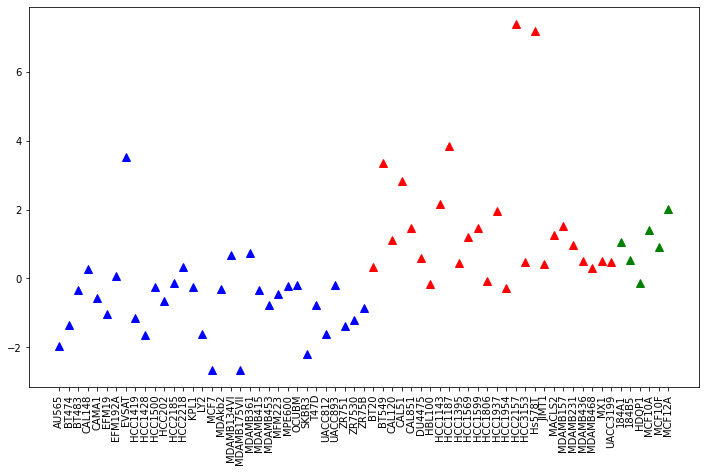

In [16]:
# 2D visualization for binary classification
binary_dpd_vals = cell_line_and_subtype["DPD"]


fig = plt.figure(figsize=(12,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)

# making ticks readable
plt.xticks(rotation='vertical')

# issues with getting an appropriate 1D plot
ax.plot(binary_dpd_vals.loc[luminal_cell_names],'^',color='blue',label='luminal',ms=8)
ax.plot(binary_dpd_vals.loc[basal_cell_names],'^',color='red',label='basal',ms=8)
ax.plot(binary_dpd_vals.loc[normal_cell_names],'^',color='green',label='normal',ms=8)

plt.show()


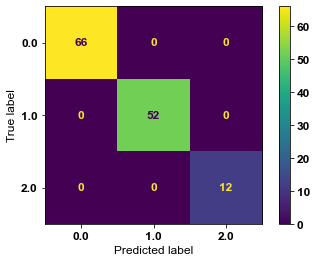

In [17]:
# multi svm
# changing strictness parameter to improve separation
svc_multi = SVC(kernel='linear',C=100)#,decision_function_shape='ovo')
svc_multi.fit(multi_svm_training.T,multi_classification)


# now let's check how well we have separated
plot_confusion_matrix(svc_multi,multi_svm_training.T,multi_classification)
# with C=100 the consion matrix is diagonal
# if C=1 the amount of misclassified cells with be small but non zero

In [18]:
#calculate norm vec and coeffs for multi svm

b_coeff_1 = - svc_multi.intercept_[0]#/linalg.norm(svc_multi.coef_[0])
norm_vec_1 = svc_multi.coef_[0]#/linalg.norm(svc_multi.coef_[0])
b_coeff_2 = - svc_multi.intercept_[1]#/linalg.norm(svc_multi.coef_[1])
norm_vec_2 = svc_multi.coef_[1]#/linalg.norm(svc_multi.coef_[1])
b_coeff_3 = - svc_multi.intercept_[2]#/linalg.norm(svc_multi.coef_[2])
norm_vec_3 = svc_multi.coef_[2]#/linalg.norm(svc_multi.coef_[2])

angle_1 = (np.arccos(np.dot(norm_vec_1,norm_vec_2)/(linalg.norm(norm_vec_1)*linalg.norm(norm_vec_2)))/np.pi)*180
angle_2 = (np.arccos(np.dot(norm_vec_2,norm_vec_3)/(linalg.norm(norm_vec_2)*linalg.norm(norm_vec_3)))/np.pi)*180
angle_3 = (np.arccos(np.dot(norm_vec_1,norm_vec_3)/(linalg.norm(norm_vec_1)*linalg.norm(norm_vec_3)))/np.pi)*180
print(angle_1)
print(angle_2)
print(angle_3)
# vectors 1 and 3 are nearly orthogonal, cool!

norm_vec_e_comb_df = pd.DataFrame(norm_vec_3/linalg.norm(norm_vec_3),index=multi_svm_training.T.columns,columns=['norm_vec_3'])
norm_vec_e_comb_df.insert(0,'norm_vec_2',norm_vec_2/linalg.norm(norm_vec_2))
norm_vec_e_comb_df.insert(0,'norm_vec_1',norm_vec_1/linalg.norm(norm_vec_1))
norm_vec_e_comb_df.sort_values(by='norm_vec_1',ascending=False)
#norm_vec_comb_df.sort_values(by='norm_vec',ascending=False)

67.87471759945493
58.83469522420223
91.21743269032866


,norm_vec_1,norm_vec_2,norm_vec_3
p-STAT5,0.482688,0.001097,-0.093850
β-CATENIN,0.415427,0.109832,0.153343
p-S6K,0.312289,0.039511,-0.034204
p-BTK,0.311327,0.032334,0.018294
p-SAPK/JNK,0.166111,-0.055212,-0.039985
p-PDPK1,0.145912,-0.038479,-0.202620
p-MAP2K3,0.145370,0.154994,-0.003551
p-MAPKAPK-2,0.139947,0.148455,-0.158847
p-MEK1/2,0.054536,0.024141,-0.398060
p-GSK3β,0.050896,0.180081,0.319456


In [19]:
# calculate dpds for multi SVM for ALL cell lines

cell_line_dpds = {label: [[],[],[]] for label in all_labels}

for smpl in full_sample_df_with_targets.T.index:
    cell_line = cellname_regex.search(smpl)
    DPD_val_1 =  - (b_coeff_1 - np.dot(full_sample_df_with_targets.T.loc[smpl],norm_vec_1))
    DPD_val_2 =  - (b_coeff_2 - np.dot(full_sample_df_with_targets.T.loc[smpl],norm_vec_2))
    DPD_val_3 =  - (b_coeff_3 - np.dot(full_sample_df_with_targets.T.loc[smpl],norm_vec_3))
    cell_line_dpds[cell_line.group(1)][0].append(DPD_val_1)
    cell_line_dpds[cell_line.group(1)][1].append(DPD_val_2)
    cell_line_dpds[cell_line.group(1)][2].append(DPD_val_3)
        
mean_dpd_1 = {label: statistics.mean(val[0]) for label, val in cell_line_dpds.items()}
mean_dpd_2 = {label: statistics.mean(val[1]) for label, val in cell_line_dpds.items()}
mean_dpd_3 = {label: statistics.mean(val[2]) for label, val in cell_line_dpds.items()}


copy = cell_line_and_subtype.copy()
copy["DPD_1"] = ""
copy["DPD_2"] = ""
copy["DPD_3"] = ""

for label, val in mean_dpd_1.items():
    print(label, val)
    copy.at[label, 'DPD_1'] = val

for label, val in mean_dpd_2.items():
    print(label)
    copy.at[label, 'DPD_2'] = val
    
for label, val in mean_dpd_3.items():
    print(label)
    copy.at[label, 'DPD_3'] = val
    
display(copy)
#cell_line_and_subtype.to_csv('cell_line_and_subtype_test.csv')

184A1 -4.465294008009432
184B5 -2.2865268882431202
AU565 8.298948032072289
BT20 -1.4167189626706627
BT474 5.764670002257292
BT483 1.3841957819377522
BT549 -14.275337412461825
CAL120 -4.7141398195046404
CAL148 -1.18494087380252
CAL51 -12.072964785489452
CAL851 -6.168810474189965
CAMA1 2.429567601766285
DU4475 -2.4915133113357744
EFM19 4.428641524278206
EFM192A -0.3480372581770649
EVSAT -14.940182519140139
HBL100 0.6574776135420661
HCC1143 -9.180077311813784
HCC1187 -16.352256273478034
HCC1395 -1.8982010258751187
HCC1419 4.900967529334551
HCC1428 6.997352966920307
HCC1500 1.041579678488435
HCC1569 -5.155534871526952
HCC1599 -6.170904724576558
HCC1806 0.3025665510634042
HCC1937 -8.34566497514058
HCC1954 1.177266711816227
HCC202 2.7651927711167654
HCC2157 -31.390793400461387
HCC2185 0.6075682001766594
HCC2218 -1.4455323591794822
HCC3153 -2.0039998293603984
HDQP1 0.6177039948842202
Hs578T -30.579763685799488
JIMT1 -1.8371299186817687
KPL1 1.00701407057179
LY2 6.915348728861266
MACLS2 -5.411

,Type,ER,PR,HER2,PI3K,p53,RAS,DPD,DPD_1,DPD_2,DPD_3
Cell line,,,,,,,,,,,
184A1,Normal,NaN,NaN,NaN,NaN,NaN,NaN,1.05104,-4.46529,-1.1093,-0.850631
184B5,Normal,NaN,NaN,NaN,NaN,NaN,NaN,0.538204,-2.28653,-1.16681,-0.652504
AU565,L,NaN,NaN,NaN,NaN,TP53_R175H,NaN,-1.95341,8.29895,2.52592,1.67289
BT20,B,neg,neg,neg,PIK3CA_P539R,TP53_K132Q,?,0.333468,-1.41672,2.32612,3.28596
BT474,L,pos,pos,pos,NaN,NaN,NaN,-1.35689,5.76467,2.62678,1.6324
...,...,...,...,...,...,...,...,...,...,...,...
UACC812,L,pos,pos/neg,pos,NaN,NaN,NaN,-1.60467,6.81735,2.01211,0.249108
UACC893,L,neg,neg,pos,NaN,NaN,NaN,-0.2001,0.850112,3.08409,2.4224
ZR751,L,pos,pos/neg,neg,NaN,NaN,NaN,-1.39551,5.92874,3.50022,4.82474


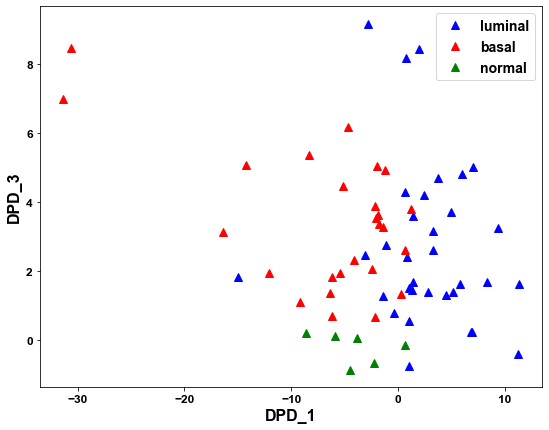

In [20]:
# 2D visualization fpr multi svm
dpd_vals = copy[["DPD_1", "DPD_2", "DPD_3"]]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)


xax=0
yax=2

ax.plot(dpd_vals.loc[luminal_cell_names].iloc[:,xax],dpd_vals.loc[luminal_cell_names].iloc[:,yax],'^',color='blue',label='luminal',ms=8)
ax.plot(dpd_vals.loc[basal_cell_names].iloc[:,xax],dpd_vals.loc[basal_cell_names].iloc[:,yax],'^',color='red',label='basal',ms=8)
ax.plot(dpd_vals.loc[normal_cell_names].iloc[:,xax],dpd_vals.loc[normal_cell_names].iloc[:,yax],'^',color='green',label='normal',ms=8)

ax.set_xlabel('DPD_1',**fontLabel)
ax.set_ylabel('DPD_3',**fontLabel)


ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()



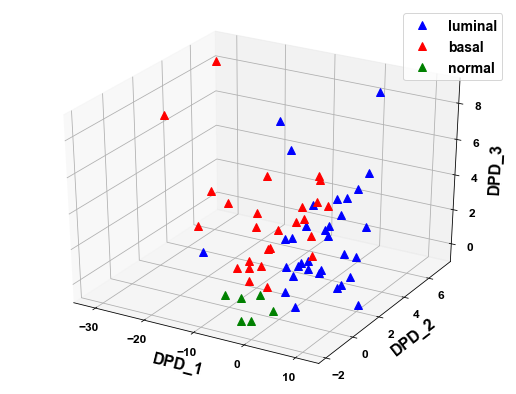

In [21]:
# 3D visualization


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)

#plt.suptitle('PhosphoSite fold changes',**fontTitle)

ax.plot(dpd_vals.loc[luminal_cell_names].iloc[:,0],dpd_vals.loc[luminal_cell_names].iloc[:,1],dpd_vals.loc[luminal_cell_names].iloc[:,2],'^',color='blue',label='luminal',ms=8)
ax.plot(dpd_vals.loc[basal_cell_names].iloc[:,0],dpd_vals.loc[basal_cell_names].iloc[:,1],dpd_vals.loc[basal_cell_names].iloc[:,2],'^',color='red',label='basal',ms=8)
ax.plot(dpd_vals.loc[normal_cell_names].iloc[:,0],dpd_vals.loc[normal_cell_names].iloc[:,1],dpd_vals.loc[normal_cell_names].iloc[:,2],'^',color='green',label='normal',ms=8)


#for smpl in drugs12pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('DPD_1',**fontLabel)
ax.set_ylabel('DPD_2',**fontLabel)
ax.set_zlabel('DPD_3',**fontLabel)

#ax.set_xlim(-15,35)
#ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()



In [22]:
# Dear Amy, you have calculated average DPD for all samples that mention specific cell line
# Initially we used SVM to separate "full" samples
# Actually, this is surprise, but I am glad that still we see some separation of different cell lines
# The problem is that if we treat cells with some inhibitor, they can change their state
# This is why we do not see clear separation when we average over all samples
# However, if we see how the points look for "full" samples, you will see clear sepatation


######  DPD for full samples only ######

# So, let's calculate DPDs for "full" samples

DPDs_3D = pd.DataFrame(np.zeros((len(full_sample_df_with_targets.columns),3)),index=full_sample_df_with_targets.columns,columns=['DPD_1','DPD_2','DPD_3'])

for smpl in full_sample_df_with_targets.columns:
    DPDs_3D.at[smpl,'DPD_1'] = - (b_coeff_1 - np.dot(full_sample_df_with_targets.loc[:,smpl],norm_vec_1))
    DPDs_3D.at[smpl,'DPD_2'] = - (b_coeff_2 - np.dot(full_sample_df_with_targets.loc[:,smpl],norm_vec_2))
    DPDs_3D.at[smpl,'DPD_3'] = - (b_coeff_3 - np.dot(full_sample_df_with_targets.loc[:,smpl],norm_vec_3))
        
DPDs_3D_full = DPDs_3D.filter(regex='_full_full_',axis=0).copy()
#DPDs_3D_full

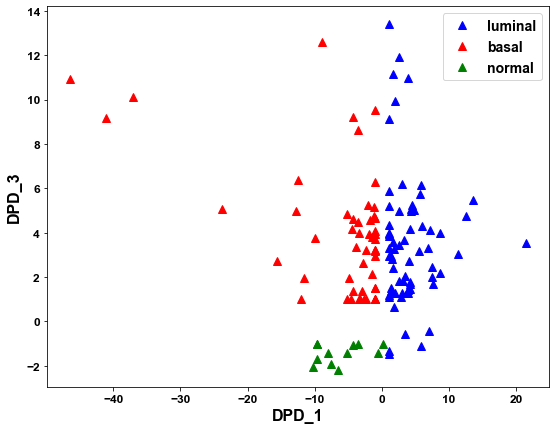

In [23]:
# 2D visualization fpr multi svm
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)


xax=0
yax=2

ax.plot(DPDs_3D_full.loc[luminal_samples.columns].iloc[:,xax],DPDs_3D_full.loc[luminal_samples.columns].iloc[:,yax],'^',color='blue',label='luminal',ms=8)
ax.plot(DPDs_3D_full.loc[basal_samples.columns].iloc[:,xax],DPDs_3D_full.loc[basal_samples.columns].iloc[:,yax],'^',color='red',label='basal',ms=8)
ax.plot(DPDs_3D_full.loc[normal_samples.columns].iloc[:,xax],DPDs_3D_full.loc[normal_samples.columns].iloc[:,yax],'^',color='green',label='normal',ms=8)

ax.set_xlabel('DPD_1',**fontLabel)
ax.set_ylabel('DPD_3',**fontLabel)


ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()

# now we see clear separation of luminal and basal samples, but

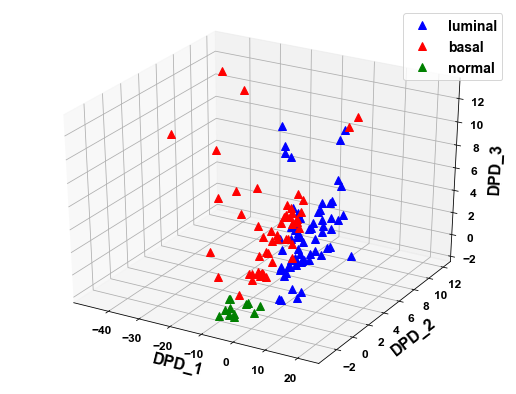

In [24]:
# 3D visualization


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)

#plt.suptitle('PhosphoSite fold changes',**fontTitle)

ax.plot(DPDs_3D_full.loc[luminal_samples.columns].iloc[:,0],DPDs_3D_full.loc[luminal_samples.columns].iloc[:,1],DPDs_3D_full.loc[luminal_samples.columns].iloc[:,2],'^',color='blue',label='luminal',ms=8)
ax.plot(DPDs_3D_full.loc[basal_samples.columns].iloc[:,0],DPDs_3D_full.loc[basal_samples.columns].iloc[:,1],DPDs_3D_full.loc[basal_samples.columns].iloc[:,2],'^',color='red',label='basal',ms=8)
ax.plot(DPDs_3D_full.loc[normal_samples.columns].iloc[:,0],DPDs_3D_full.loc[normal_samples.columns].iloc[:,1],DPDs_3D_full.loc[normal_samples.columns].iloc[:,2],'^',color='green',label='normal',ms=8)


#for smpl in drugs12pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('DPD_1',**fontLabel)
ax.set_ylabel('DPD_2',**fontLabel)
ax.set_zlabel('DPD_3',**fontLabel)

#ax.set_xlim(-15,35)
#ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()



41.86027231074864


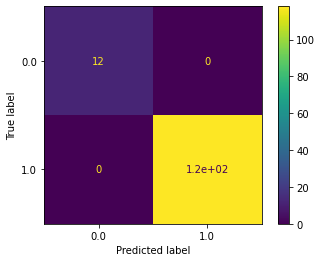

In [16]:
# Now this is interesting, we see that SVM clearly separates the samples, but still we cannot say 
# that there is one coordinate that can serve as a score of cell's "cancerness", i.e. whether it is cancer or normal
# From biological perspective, it would be better if we would have it.
# So let's do the following, instead of using multi-class SVM we will run 2 binary SVMs
# One SVM separating basal and luminal BC we have already run
# So we need to run only 1 additional SVM, normal vs cancer

svc_canc = SVC(kernel='linear',C=100)
svc_canc.fit(pd.concat([luminal_samples,basal_samples,normal_samples],axis=1).T, list(np.ones(len(luminal_samples.columns))) + list(np.ones(len(basal_samples.columns))) + list(np.zeros(len(normal_samples.columns))))

b_coeff_canc = - svc_canc.intercept_[0]/linalg.norm(svc_canc.coef_[0])
norm_vec_canc = svc_canc.coef_[0]/linalg.norm(svc_canc.coef_[0])
canc_centroid = (basal_centroid + luminal_centroid)/2.0
s_vec_canc = (canc_centroid - normal_centroid)/linalg.norm(canc_centroid - normal_centroid)

angle_canc = (np.arccos(np.dot(norm_vec_canc,s_vec_canc))/np.pi)*180
print(angle_canc)

plot_confusion_matrix(svc_canc,pd.concat([luminal_samples,basal_samples,normal_samples],axis=1).T, list(np.ones(len(luminal_samples.columns))) + list(np.ones(len(basal_samples.columns))) + list(np.zeros(len(normal_samples.columns))))

In [17]:
# now let's assemble dataframe with 2 normal and s vectors which will be used
# we do it mainly to aviod mistakes, because now we have generated too many vectors and it is easy to mess things up

norm_vec_2D_df = pd.DataFrame(np.array([norm_vec_canc,np.array(s_vec_canc),norm_vec_train,np.array(s_vec_train)]),columns=luminal_samples.index,index=['norm_vec_canc','s_vec_canc','norm_vec_LB','s_vec_LB']).T
norm_vec_2D_df.to_csv('STV_2D.csv')
norm_vec_2D_df

,norm_vec_canc,s_vec_canc,norm_vec_LB,s_vec_LB
p-p53,0.105431,0.099701,0.031785,-0.003762
p-SAPK/JNK,-0.040538,-0.023165,-0.166111,-0.008476
p-MAPKAPK-2,-0.111480,0.098871,-0.139947,0.088566
p-BTK,0.038919,0.003146,-0.311327,-0.005705
cleaved PARP,-0.051419,-0.028484,0.218140,0.025408
Cyclin B1,-0.362856,-0.281083,0.108390,0.271714
GAPDH,0.128833,0.219644,-0.035264,-0.031754
p-S6,0.269193,0.677481,0.014391,0.610368
p-MEK1/2,-0.311688,-0.032122,-0.054536,-0.066184
p-SRC,-0.079177,0.026531,0.124095,0.042059


In [18]:
# now lets's calculate our 2D DPD
DPDs_2D = pd.DataFrame(np.zeros((len(full_sample_df_with_targets.columns),2)),index=full_sample_df_with_targets.columns,columns=['DPD_canc','DPD_LB'])

for smpl in full_sample_df_with_targets.columns:
    DPDs_2D.at[smpl,'DPD_canc'] = - (b_coeff_canc - np.dot(full_sample_df_with_targets.loc[:,smpl],norm_vec_2D_df['norm_vec_canc']))/np.dot(norm_vec_2D_df['norm_vec_canc'],norm_vec_2D_df['s_vec_canc'])
    DPDs_2D.at[smpl,'DPD_LB'] = - (b_coeff_train - np.dot(full_sample_df_with_targets.loc[:,smpl],norm_vec_2D_df['norm_vec_LB']))/np.dot(norm_vec_2D_df['norm_vec_LB'],norm_vec_2D_df['s_vec_LB'])
        
DPDs_2D_full = DPDs_2D.filter(regex='_full_full_',axis=0).copy()
DPDs_2D_full.to_csv('DPDs_2D_full.csv')

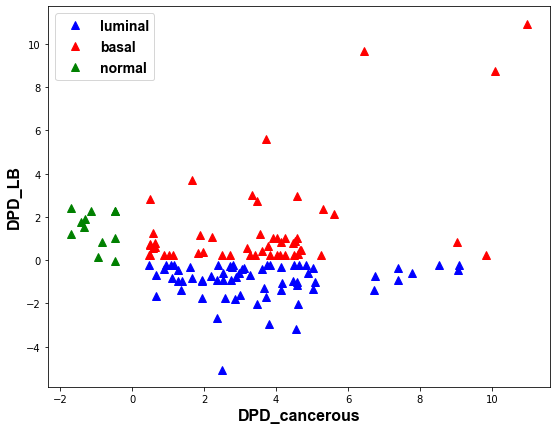

In [19]:
# now let's see what we have
# 2D visualization for multi svm
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)


ax.plot(DPDs_2D_full.loc[luminal_samples.columns].iloc[:,0],DPDs_2D_full.loc[luminal_samples.columns].iloc[:,1],'^',color='blue',label='luminal',ms=8)
ax.plot(DPDs_2D_full.loc[basal_samples.columns].iloc[:,0],DPDs_2D_full.loc[basal_samples.columns].iloc[:,1],'^',color='red',label='basal',ms=8)
ax.plot(DPDs_2D_full.loc[normal_samples.columns].iloc[:,0],DPDs_2D_full.loc[normal_samples.columns].iloc[:,1],'^',color='green',label='normal',ms=8)

ax.set_xlabel('DPD_cancerous',**fontLabel)
ax.set_ylabel('DPD_LB',**fontLabel)


ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()

# Finally we have what we want!
# As you can see, now DPD_canc reflects "cancerness" of the cells
# and DPD_LB separates luminal cancers from basal ones

In [20]:
# now I am curious how different norm_vec's and s_vec's for canc and LB separation
angle_n = (np.arccos(np.dot(norm_vec_2D_df['norm_vec_canc'],norm_vec_2D_df['norm_vec_LB']))/np.pi)*180
angle_s = (np.arccos(np.dot(norm_vec_2D_df['s_vec_canc'],norm_vec_2D_df['s_vec_LB']))/np.pi)*180
print(angle_n)
print(angle_s)

# it is interesting that norm_vec's are nearly orthogonal
# this means that cell's "cancerness" and cancer type are indeed different independent properties

97.34826511907423
68.12801963893097


In [21]:
# assigning outputs to different modules
# off-topic comment: how I hate that they did not measure phospho-EGFR directly, that is simply stupid!
# Actually, this is strange but p-ERK is announced in the paper but absent in the data (?!)

# I decided to make a special xlsx file for this

modules_df = pd.read_excel('BMRA_modules.xlsx',index_col=0)
modules_df

# Ideally we should use p-ERK instead of p-MEK, but we have what we have

removable_targets = modules_df["Output"]

# here we have to apply this drop not to df with "full" samples only, but to initial dataframe
# because further we will need data from all these samples

removed_modules_all = full_sample_df_with_targets.drop(removable_targets)
removed_modules = removed_modules_all.filter(regex='_full_full_')
#removed_modules
modules_df

,Output,Perturbation
Module_name,,
EGFR,p-p38,iEGFR
PI3K_AKT,p-AKT(473),iPI3K
mTOR,p-S6,imTOR
MEK_ERK,p-p90RSK,iMEK
PKC,p-GSK3β,iPKC


In [22]:
##################################################################
# This code can be reduced? 

# OR: a bit, please see below

In [23]:
# in regex "|" means OR, so, we can just make a regex with cell lines names listed using "|"
luminal_samples_mod = removed_modules.filter(regex='|'.join(luminal_cell_names))
basal_samples_mod = removed_modules.filter(regex='|'.join(basal_cell_names))
normal_samples_mod = removed_modules.filter(regex='|'.join(normal_cell_names))

# calculate the centroid of the luminal and centroid samples
luminal_centroid_mod = luminal_samples_mod.mean(axis=1)
basal_centroid_mod = basal_samples_mod.mean(axis=1)
normal_centroid_mod = normal_samples_mod.mean(axis=1)

# we now know that we have to build 2 STVs and DPDs separately to get the separation that we need
# so we will not repeat all the stuff

50.88338709866106


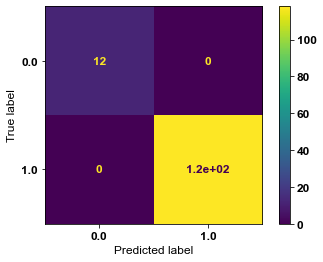

In [24]:
# cancer vs non-cancer part

svc_canc_mod = SVC(kernel='linear',C=100)
svc_canc_mod.fit(pd.concat([luminal_samples_mod,basal_samples_mod,normal_samples_mod],axis=1).T, list(np.ones(len(luminal_samples_mod.columns))) + list(np.ones(len(basal_samples_mod.columns))) + list(np.zeros(len(normal_samples_mod.columns))))

b_coeff_canc_mod = - svc_canc_mod.intercept_[0]/linalg.norm(svc_canc_mod.coef_[0])
norm_vec_canc_mod = svc_canc_mod.coef_[0]/linalg.norm(svc_canc_mod.coef_[0])
canc_centroid_mod = (basal_centroid_mod + luminal_centroid_mod)/2.0
s_vec_canc_mod = (canc_centroid_mod - normal_centroid_mod)/linalg.norm(canc_centroid_mod - normal_centroid_mod)

angle_canc_mod = (np.arccos(np.dot(norm_vec_canc_mod,s_vec_canc_mod))/np.pi)*180
print(angle_canc_mod)

plot_confusion_matrix(svc_canc_mod,pd.concat([luminal_samples_mod,basal_samples_mod,normal_samples_mod],axis=1).T, list(np.ones(len(luminal_samples_mod.columns))) + list(np.ones(len(basal_samples_mod.columns))) + list(np.zeros(len(normal_samples_mod.columns))))

73.67026435706181


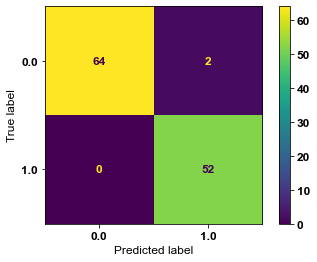

In [25]:
# luminal vs basal part

# I had to increase C to keep clear separation
svc_LB_mod = SVC(kernel='linear',C=1000)
svc_LB_mod.fit(pd.concat([luminal_samples_mod,basal_samples_mod],axis=1).T, list(np.zeros(len(luminal_samples_mod.columns))) + list(np.ones(len(basal_samples_mod.columns))))

b_coeff_LB_mod = - svc_LB_mod.intercept_[0]/linalg.norm(svc_LB_mod.coef_[0])
norm_vec_LB_mod = svc_LB_mod.coef_[0]/linalg.norm(svc_LB_mod.coef_[0])
canc_centroid_mod = (basal_centroid_mod + luminal_centroid_mod)/2.0
s_vec_LB_mod = (basal_centroid_mod - luminal_centroid_mod)/linalg.norm(basal_centroid_mod - luminal_centroid_mod)

angle_LB_mod = (np.arccos(np.dot(norm_vec_LB_mod,s_vec_LB_mod))/np.pi)*180
print(angle_LB_mod)

plot_confusion_matrix(svc_LB_mod,pd.concat([luminal_samples_mod,basal_samples_mod],axis=1).T, list(np.zeros(len(luminal_samples_mod.columns))) + list(np.ones(len(basal_samples_mod.columns))))

In [26]:
# assembling dataframe with 2 normal and s vectors which will be used

norm_vec_2D_df_mod = pd.DataFrame(np.array([norm_vec_canc_mod,np.array(s_vec_canc_mod),norm_vec_LB_mod,np.array(s_vec_LB_mod)]),columns=luminal_samples_mod.index,index=['norm_vec_canc','s_vec_canc','norm_vec_LB','s_vec_LB']).T
norm_vec_2D_df_mod.to_csv('STV_2D_mod.csv')
norm_vec_2D_df_mod

,norm_vec_canc,s_vec_canc,norm_vec_LB,s_vec_LB
p-p53,-0.055434,0.154228,-0.056517,-0.005012
p-SAPK/JNK,-0.042065,-0.035834,-0.296425,-0.011293
p-MAPKAPK-2,0.078920,0.152944,-0.048311,0.118003
p-BTK,0.108120,0.004867,-0.512530,-0.007601
cleaved PARP,-0.040541,-0.044063,0.232163,0.033853
Cyclin B1,-0.301273,-0.434810,0.071234,0.362028
GAPDH,0.338424,0.339770,-0.047076,-0.042309
p-MEK1/2,-0.406748,-0.049690,-0.057236,-0.088183
p-SRC,-0.111638,0.041041,0.249842,0.056039
p-4EBP1,0.256130,0.648122,-0.004461,-0.091364


In [27]:
# now lets's calculate our 2D DPD
DPDs_2D_mod = pd.DataFrame(np.zeros((len(full_sample_df_with_targets.columns),2)),index=removed_modules_all.columns,columns=['DPD_canc','DPD_LB'])

for smpl in removed_modules_all.columns:
    DPDs_2D_mod.at[smpl,'DPD_canc'] = - (b_coeff_canc_mod - np.dot(removed_modules_all.loc[:,smpl],norm_vec_2D_df_mod['norm_vec_canc']))/np.dot(norm_vec_2D_df_mod['norm_vec_canc'],norm_vec_2D_df_mod['s_vec_canc'])
    DPDs_2D_mod.at[smpl,'DPD_LB'] = - (b_coeff_LB_mod - np.dot(removed_modules_all.loc[:,smpl],norm_vec_2D_df_mod['norm_vec_LB']))/np.dot(norm_vec_2D_df_mod['norm_vec_LB'],norm_vec_2D_df_mod['s_vec_LB'])
        
DPDs_2D_full_mod = DPDs_2D_mod.filter(regex='_full_full_',axis=0).copy()
DPDs_2D_full_mod

,DPD_canc,DPD_LB
_e153_UACC3199_A_full_full_singlets_full.fcs.fcs,2.805222,0.055454
_e244_UACC3199_B_full_full_singlets_full.fcs.fcs,3.220131,0.138104
_e269_184A1_A_full_full_singlets_full.fcs.fcs,-0.780931,0.936139
_e360_184A1_B_full_full_singlets_full.fcs.fcs,-1.166709,1.549380
_b994_HCC1428_A_full_full_singlets_full.fcs.fcs,5.644776,-1.589309
...,...,...
_c624_T47D_B_full_full_singlets_full.fcs.fcs,1.761130,-1.369100
_b389_ZR75B_B_full_full_singlets_full.fcs.fcs,2.538734,-1.111438
_b66_ZR75B_A_full_full_singlets_full.fcs.fcs,2.881533,-1.599001
_d427_CAL851_A_full_full_singlets_full.fcs.fcs,0.330700,1.286239


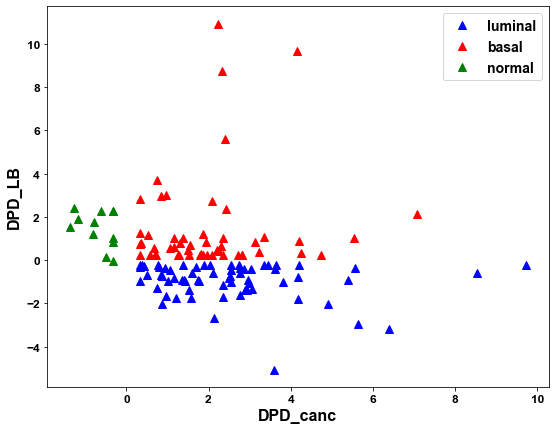

In [28]:
# now let's see what we have
# 2D visualization for multi svm
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 12} 
fontLegend =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 14} 
plt.rc('font', **fontAxes)


ax.plot(DPDs_2D_full_mod.loc[luminal_samples_mod.columns].iloc[:,0],DPDs_2D_full.loc[luminal_samples_mod.columns].iloc[:,1],'^',color='blue',label='luminal',ms=8)
ax.plot(DPDs_2D_full_mod.loc[basal_samples_mod.columns].iloc[:,0],DPDs_2D_full.loc[basal_samples_mod.columns].iloc[:,1],'^',color='red',label='basal',ms=8)
ax.plot(DPDs_2D_full_mod.loc[normal_samples_mod.columns].iloc[:,0],DPDs_2D_full.loc[normal_samples_mod.columns].iloc[:,1],'^',color='green',label='normal',ms=8)

ax.set_xlabel('DPD_canc',**fontLabel)
ax.set_ylabel('DPD_LB',**fontLabel)


ax.legend(numpoints=1,prop=fontLegend,ncol=1)
plt.show()

# Finally we have what we want!
# As you can see, now DPD_canc reflects "cancerness" of the cells
# and DPD_LB separates luminal cancers from basal ones

In [29]:
# now I am curious how different norm_vec's and s_vec's for canc and LB separation
angle_n_mod = (np.arccos(np.dot(norm_vec_2D_df_mod['norm_vec_canc'],norm_vec_2D_df_mod['norm_vec_LB']))/np.pi)*180
angle_s_mod = (np.arccos(np.dot(norm_vec_2D_df_mod['s_vec_canc'],norm_vec_2D_df_mod['s_vec_LB']))/np.pi)*180
print(angle_n_mod)
print(angle_s_mod)

# norm_vec's are still orthogonal, good

95.5650698819435
104.37835240405569


In [30]:
# now we have to calculate R_ij
# please keep in mind that all DPD's for the reduced dataspace are now calculated in DPDs_2D_mod
# so when you calculate R_ij for the DPD module you already have the values for the formula
# which is by the way is different for DPD module, please keep this in mind or ask me if needed

In [40]:
# module names
module_names = list(modules_df.index) + list(['DPD_canc','DPD_LB'])

def calculate_global_resp_matrix(cell_line_in, time_point_in):
    # calculating R_ij for the specific cell line and for the specific time point

    # number of replicates, currently 1
    repn = 1

    cell_line = cell_line_in
    time_point = time_point_in
    R_global = pd.DataFrame(np.zeros((len(module_names),repn*len(modules_df.index))),columns=modules_df['Perturbation'],index=module_names)

    # filling signalling part
    for mod_name in modules_df.index:
        #print(mod_name)
        for pert_name in modules_df['Perturbation']:
            x1_regex_str = ('_\S+_'+ cell_line + '_[AB]_' + str(time_point) + '_' + pert_name + '_singlets_' + pert_name + '\.fcs\.fcs')
            x0_regex_str = ('_\S+_'+ cell_line + '_[AB]_' + str(time_point) + '_egf_singlets_egf\.fcs\.fcs')
#           print('Sample_egf:', full_sample_df_with_targets.filter(regex=x0_regex_str).loc[modules_df.loc[mod_name,'Output']])
#           print('Sample1+pert:', full_sample_df_with_targets.filter(regex=x1_regex_str).loc[modules_df.loc[mod_name,'Output']])
            x1 = full_sample_df_with_targets.filter(regex=x1_regex_str).loc[modules_df.loc[mod_name,'Output']].mean()
            x0 = full_sample_df_with_targets.filter(regex=x0_regex_str).loc[modules_df.loc[mod_name,'Output']].mean()
            R_global.at[mod_name,pert_name] = 2*(x1-x0)/(x1+x0)

    # filling DPD part
    for pert_name in modules_df['Perturbation']:
        x1_regex_str = ('_\S+_'+ cell_line + '_[AB]_' + str(time_point) + '_' + pert_name + '_singlets_' + pert_name + '\.fcs\.fcs')
        x0_regex_str = ('_\S+_'+ cell_line + '_[AB]_' + str(time_point) + '_egf_singlets_egf\.fcs\.fcs')
        x1 = DPDs_2D_mod.filter(regex=x1_regex_str,axis=0)['DPD_canc'].mean()
        x0 = DPDs_2D_mod.filter(regex=x0_regex_str,axis=0)['DPD_canc'].mean()
        R_global.at['DPD_canc',pert_name] = (x1-x0)/max(np.abs(x0),np.abs(x1))
        x1 = DPDs_2D_mod.filter(regex=x1_regex_str,axis=0)['DPD_LB'].mean()
        x0 = DPDs_2D_mod.filter(regex=x0_regex_str,axis=0)['DPD_LB'].mean()
        R_global.at['DPD_LB',pert_name] = (x1-x0)/max(np.abs(x0),np.abs(x1))

    return R_global


In [41]:
# Dear Amy, now you have to do this over all time points and over all cell lines and save each of such matrices
print(all_labels)
timestamps = [7,9,13,17,40,60]
global_resp_matrix = pd.DataFrame(index=all_labels, columns=timestamps)

for cell_line in all_labels:
    for time in timestamps:
        global_resp_matrix.at[cell_line, time] = calculate_global_resp_matrix(cell_line, time)
    


['184A1', '184B5', 'AU565', 'BT20', 'BT474', 'BT483', 'BT549', 'CAL120', 'CAL148', 'CAL51', 'CAL851', 'CAMA1', 'DU4475', 'EFM19', 'EFM192A', 'EVSAT', 'HBL100', 'HCC1143', 'HCC1187', 'HCC1395', 'HCC1419', 'HCC1428', 'HCC1500', 'HCC1569', 'HCC1599', 'HCC1806', 'HCC1937', 'HCC1954', 'HCC202', 'HCC2157', 'HCC2185', 'HCC2218', 'HCC3153', 'HDQP1', 'Hs578T', 'JIMT1', 'KPL1', 'LY2', 'MACLS2', 'MCF10A', 'MCF10F', 'MCF12A', 'MCF7', 'MDAkb2', 'MDAMB134VI', 'MDAMB157', 'MDAMB175VII', 'MDAMB231', 'MDAMB361', 'MDAMB415', 'MDAMB436', 'MDAMB453', 'MDAMB468', 'MFM223', 'MPE600', 'MX1', 'OCUBM', 'SKBR3', 'T47D', 'UACC3199', 'UACC812', 'UACC893', 'ZR751', 'ZR7530', 'ZR75B']


In [42]:
display(global_resp_matrix.at['184A1', 7])

Perturbation,iEGFR,iPI3K,imTOR,iMEK,iPKC
EGFR,0.091336,-0.106254,0.030162,-0.053481,-0.012222
PI3K_AKT,0.434009,-0.227839,0.008468,-0.018310,0.217425
mTOR,0.112874,-0.120682,0.137153,-0.452916,-0.048063
MEK_ERK,0.053428,-0.235712,-0.023306,-0.168638,-0.121178
PKC,0.376337,-0.141260,0.355959,-0.025672,0.061529
DPD_canc,-0.241906,-0.152888,0.463369,0.282586,0.050113
DPD_LB,-0.231379,-0.391214,-0.140408,-0.183523,0.028667


In [43]:
global_resp_matrix.loc['MCF7',9]

Perturbation,iEGFR,iPI3K,imTOR,iMEK,iPKC
EGFR,-0.252699,-0.478689,0.006018,-0.395359,-0.113121
PI3K_AKT,-0.300755,-0.554124,-0.064571,-0.190524,-0.166289
mTOR,-0.373539,-0.545231,-0.138548,-0.587129,-0.119527
MEK_ERK,-0.107457,-0.287179,0.053465,-0.094064,-0.106630
PKC,-0.589799,-0.655813,-0.359931,-0.271865,-0.953461
DPD_canc,-0.605500,-0.414807,-0.544261,-0.264631,-0.333167
DPD_LB,-0.139284,0.283656,0.012139,0.046384,0.341875


In [233]:
# create bar plots for selected antibodies
cell_line_plot='MDAMB231'
AB_name='p-GSK3β'
time_point = 7
bar_plot_regex = '_\S+_'+ cell_line_plot + '_[AB]_' + str(time_point) + '_i\S+_singlets_\S+\.fcs\.fcs'
bar_plot_regex_egf = '_\S+_'+ cell_line_plot + '_[AB]_' + str(time_point) + '_egf_singlets_\S+\.fcs\.fcs'
bar_plot_regex_full = '_\S+_'+ cell_line_plot + '_[AB]_full_full_singlets_full\.fcs\.fcs'


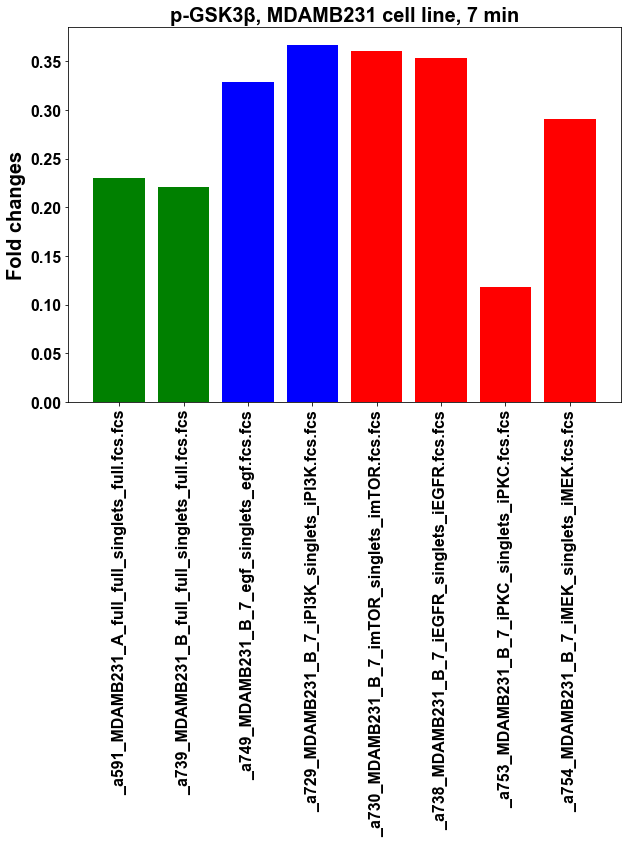

In [234]:
# make bar plot for all cells

bar_plot_df = pd.concat([full_sample_df_with_targets.filter(regex=bar_plot_regex_full),full_sample_df_with_targets.filter(regex=bar_plot_regex_egf),full_sample_df_with_targets.filter(regex=bar_plot_regex)],axis=1)

fig = plt.figure(figsize=(9,12))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

plt.title(AB_name + ', ' + cell_line_plot + ' cell line, ' + str(time_point) + ' min',**fontTitle)
plt.ylabel('Fold changes',**fontLabel)
plt.bar(bar_plot_df.columns,bar_plot_df.loc[AB_name],color=['green','green','blue','blue','red','red','red','red','red'])
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

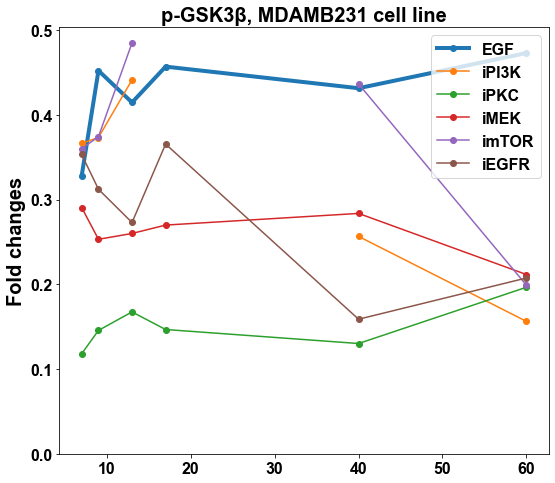

In [235]:
# plotting time course
timestamps = [7,9,13,17,40,60]

EGF_tcourse = []
iPI3K_tcourse = []
iPKC_tcourse = []
iMEK_tcourse = []
imTOR_tcourse = []
iEGFR_tcourse = []

for tpoint in timestamps:
    EGF_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_egf_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])
    iPI3K_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_iPI3K_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])
    iPKC_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_iPKC_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])
    iMEK_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_iMEK_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])
    imTOR_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_imTOR_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])
    iEGFR_tcourse.append(full_sample_df_with_targets.filter(regex='_\S+_'+ cell_line_plot + '_[AB]_' + str(tpoint) + '_iEGFR_singlets_\S+\.fcs\.fcs').mean(axis=1).loc[AB_name])


fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

plt.title(AB_name + ', ' + cell_line_plot + ' cell line',**fontTitle)
plt.ylabel('Fold changes',**fontLabel)
plt.plot(timestamps,EGF_tcourse,'o-',label='EGF',linewidth=4)
plt.plot(timestamps,iPI3K_tcourse,'o-',label='iPI3K')
plt.plot(timestamps,iPKC_tcourse,'o-',label='iPKC')
plt.plot(timestamps,iMEK_tcourse,'o-',label='iMEK')
plt.plot(timestamps,imTOR_tcourse,'o-',label='imTOR')
plt.plot(timestamps,iEGFR_tcourse,'o-',label='iEGFR')
plt.ylim(bottom=0)
plt.legend()
fig.tight_layout()
plt.show()


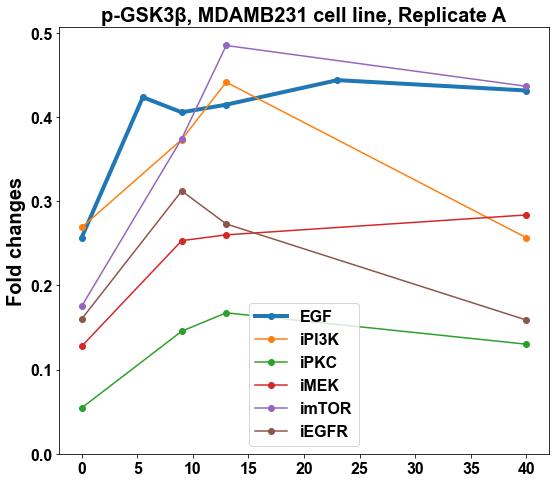

In [236]:
# now let's plot by replicate
# this one is for A
cline_df = full_sample_df_with_targets.filter(regex=cell_line_plot)
perts = ['EGF','iPI3K','iPKC','iMEK','imTOR','iEGFR']

EGF_tcourse = []
EGF_tpoints = []
iPI3K_tcourse = []
iPI3K_tpoints = []
iPKC_tcourse = []
iPKC_tpoints = []
iMEK_tcourse = []
iMEK_tpoints = []
imTOR_tcourse = []
imTOR_tpoints = []
iEGFR_tcourse = []
iEGFR_tpoints = []

tcourse_regex = re.compile('_\S+_'+ cell_line_plot + '_A_(\d+\.*\d*)_(\S+)_singlets_\S+\.fcs\.fcs')
for dpoint in cline_df.columns:
    srch = tcourse_regex.search(dpoint)
    if srch:
        if srch.group(2) == 'egf':
            EGF_tcourse.append(cline_df.loc[AB_name,dpoint])
            EGF_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iPI3K':
            iPI3K_tcourse.append(cline_df.loc[AB_name,dpoint])
            iPI3K_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iPKC':
            iPKC_tcourse.append(cline_df.loc[AB_name,dpoint])
            iPKC_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iMEK':
            iMEK_tcourse.append(cline_df.loc[AB_name,dpoint])
            iMEK_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'imTOR':
            imTOR_tcourse.append(cline_df.loc[AB_name,dpoint])
            imTOR_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iEGFR':
            iEGFR_tcourse.append(cline_df.loc[AB_name,dpoint])
            iEGFR_tpoints.append(float(srch.group(1)))

fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

EGF_A_df = pd.DataFrame(np.array([EGF_tpoints,EGF_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPI3K_A_df = pd.DataFrame(np.array([iPI3K_tpoints,iPI3K_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPKC_A_df = pd.DataFrame(np.array([iPKC_tpoints,iPKC_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iMEK_A_df = pd.DataFrame(np.array([iMEK_tpoints,iMEK_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
imTOR_A_df = pd.DataFrame(np.array([imTOR_tpoints,imTOR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iEGFR_A_df = pd.DataFrame(np.array([iEGFR_tpoints,iEGFR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')

plt.title(AB_name + ', ' + cell_line_plot + ' cell line, Replicate A',**fontTitle)
plt.ylabel('Fold changes',**fontLabel)
plt.plot(np.array(EGF_A_df['tpoints']),np.array(EGF_A_df['tcourse']),'o-',label='EGF',linewidth=4)
plt.plot(np.array(iPI3K_A_df['tpoints']),np.array(iPI3K_A_df['tcourse']),'o-',label='iPI3K')
plt.plot(np.array(iPKC_A_df['tpoints']),np.array(iPKC_A_df['tcourse']),'o-',label='iPKC')
plt.plot(np.array(iMEK_A_df['tpoints']),np.array(iMEK_A_df['tcourse']),'o-',label='iMEK')
plt.plot(np.array(imTOR_A_df['tpoints']),np.array(imTOR_A_df['tcourse']),'o-',label='imTOR')
plt.plot(np.array(iEGFR_A_df['tpoints']),np.array(iEGFR_A_df['tcourse']),'o-',label='iEGFR')
plt.ylim(bottom=0)
plt.legend()
fig.tight_layout()
plt.show()



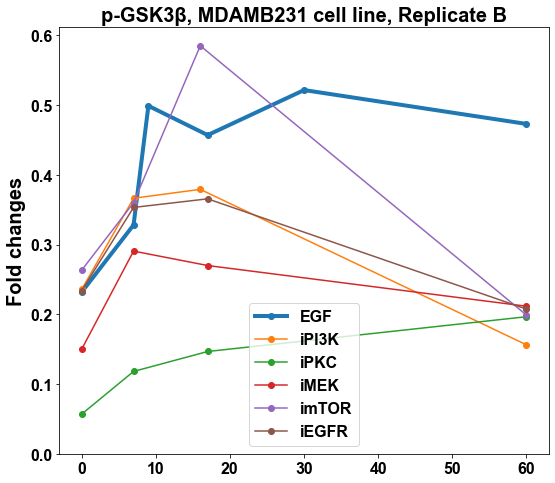

In [237]:
# now let's plot by replicate
# this one is for A
cline_df = full_sample_df_with_targets.filter(regex=cell_line_plot)
perts = ['EGF','iPI3K','iPKC','iMEK','imTOR','iEGFR']

EGF_tcourse = []
EGF_tpoints = []
iPI3K_tcourse = []
iPI3K_tpoints = []
iPKC_tcourse = []
iPKC_tpoints = []
iMEK_tcourse = []
iMEK_tpoints = []
imTOR_tcourse = []
imTOR_tpoints = []
iEGFR_tcourse = []
iEGFR_tpoints = []

tcourse_regex = re.compile('_\S+_'+ cell_line_plot + '_B_(\d+\.*\d*)_(\S+)_singlets_\S+\.fcs\.fcs')
for dpoint in cline_df.columns:
    srch = tcourse_regex.search(dpoint)
    if srch:
        if srch.group(2) == 'egf':
            EGF_tcourse.append(cline_df.loc[AB_name,dpoint])
            EGF_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iPI3K':
            iPI3K_tcourse.append(cline_df.loc[AB_name,dpoint])
            iPI3K_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iPKC':
            iPKC_tcourse.append(cline_df.loc[AB_name,dpoint])
            iPKC_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iMEK':
            iMEK_tcourse.append(cline_df.loc[AB_name,dpoint])
            iMEK_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'imTOR':
            imTOR_tcourse.append(cline_df.loc[AB_name,dpoint])
            imTOR_tpoints.append(float(srch.group(1)))
        if srch.group(2) == 'iEGFR':
            iEGFR_tcourse.append(cline_df.loc[AB_name,dpoint])
            iEGFR_tpoints.append(float(srch.group(1)))

fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

EGF_B_df = pd.DataFrame(np.array([EGF_tpoints,EGF_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPI3K_B_df = pd.DataFrame(np.array([iPI3K_tpoints,iPI3K_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPKC_B_df = pd.DataFrame(np.array([iPKC_tpoints,iPKC_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iMEK_B_df = pd.DataFrame(np.array([iMEK_tpoints,iMEK_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
imTOR_B_df = pd.DataFrame(np.array([imTOR_tpoints,imTOR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iEGFR_B_df = pd.DataFrame(np.array([iEGFR_tpoints,iEGFR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')

plt.title(AB_name + ', ' + cell_line_plot + ' cell line, Replicate B',**fontTitle)
plt.ylabel('Fold changes',**fontLabel)
plt.plot(np.array(EGF_B_df['tpoints']),np.array(EGF_B_df['tcourse']),'o-',label='EGF',linewidth=4)
plt.plot(np.array(iPI3K_B_df['tpoints']),np.array(iPI3K_B_df['tcourse']),'o-',label='iPI3K')
plt.plot(np.array(iPKC_B_df['tpoints']),np.array(iPKC_B_df['tcourse']),'o-',label='iPKC')
plt.plot(np.array(iMEK_B_df['tpoints']),np.array(iMEK_B_df['tcourse']),'o-',label='iMEK')
plt.plot(np.array(imTOR_B_df['tpoints']),np.array(imTOR_B_df['tcourse']),'o-',label='imTOR')
plt.plot(np.array(iEGFR_B_df['tpoints']),np.array(iEGFR_B_df['tcourse']),'o-',label='iEGFR')
plt.ylim(bottom=0)
plt.legend()
fig.tight_layout()
plt.show()



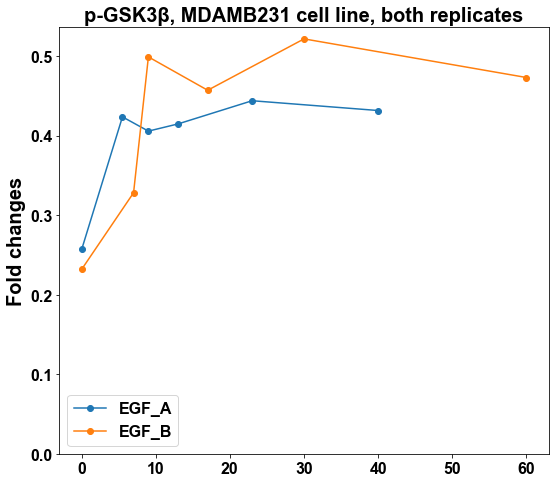

In [238]:
fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

EGF_B_df = pd.DataFrame(np.array([EGF_tpoints,EGF_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPI3K_B_df = pd.DataFrame(np.array([iPI3K_tpoints,iPI3K_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iPKC_B_df = pd.DataFrame(np.array([iPKC_tpoints,iPKC_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iMEK_B_df = pd.DataFrame(np.array([iMEK_tpoints,iMEK_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
imTOR_B_df = pd.DataFrame(np.array([imTOR_tpoints,imTOR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')
iEGFR_B_df = pd.DataFrame(np.array([iEGFR_tpoints,iEGFR_tcourse]),index=['tpoints','tcourse']).T.sort_values(by='tpoints')

plt.title(AB_name + ', ' + cell_line_plot + ' cell line, both replicates',**fontTitle)
plt.ylabel('Fold changes',**fontLabel)
plt.plot(np.array(EGF_A_df['tpoints']),np.array(EGF_A_df['tcourse']),'o-',label='EGF_A')
plt.plot(np.array(EGF_B_df['tpoints']),np.array(EGF_B_df['tcourse']),'o-',label='EGF_B')
plt.ylim(bottom=0)
plt.legend()
fig.tight_layout()
plt.show()

